In [225]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon


plt.style.use('default')
plt.rcParams['figure.figsize'] = [12.0,8.0]

df = pd.read_csv('data/train.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})
df['fecha'] = pd.to_datetime(df['fecha'])
df['anio de publicacion'] = df['fecha'].dt.year
df["mes de publicacion"] = df['fecha'].dt.month
df['preciousd'] = df['precio']/20

In [226]:
def fix_state_names(state_name):
    fix_these = {
        'México': 'Edo. de México',
        'San Luis Potosí': 'San luis Potosí',
        'Baja California': 'Baja California Norte'
    }
    
    return fix_these.get(state_name, state_name)

In [227]:
df['metrostotales'].fillna(df['metroscubiertos'], inplace=True)
df['metroscubiertos'].fillna(df['metrostotales'], inplace=True)

En la siguiente celda esta el filtrado, cambiar lo que se filtra y ver los demas casos

In [228]:
mono = df[df["habitaciones"]==1]

In [229]:
mono['preciom2usd'] = mono['preciousd'] / mono['metrostotales']

/home/peter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [230]:
plotear = mono.tipodepropiedad.value_counts().to_frame()
plotear = plotear.sort_values(by="tipodepropiedad").reset_index()
plotear = plotear.rename(columns={"index":"tipo","tipodepropiedad":"cuenta"})

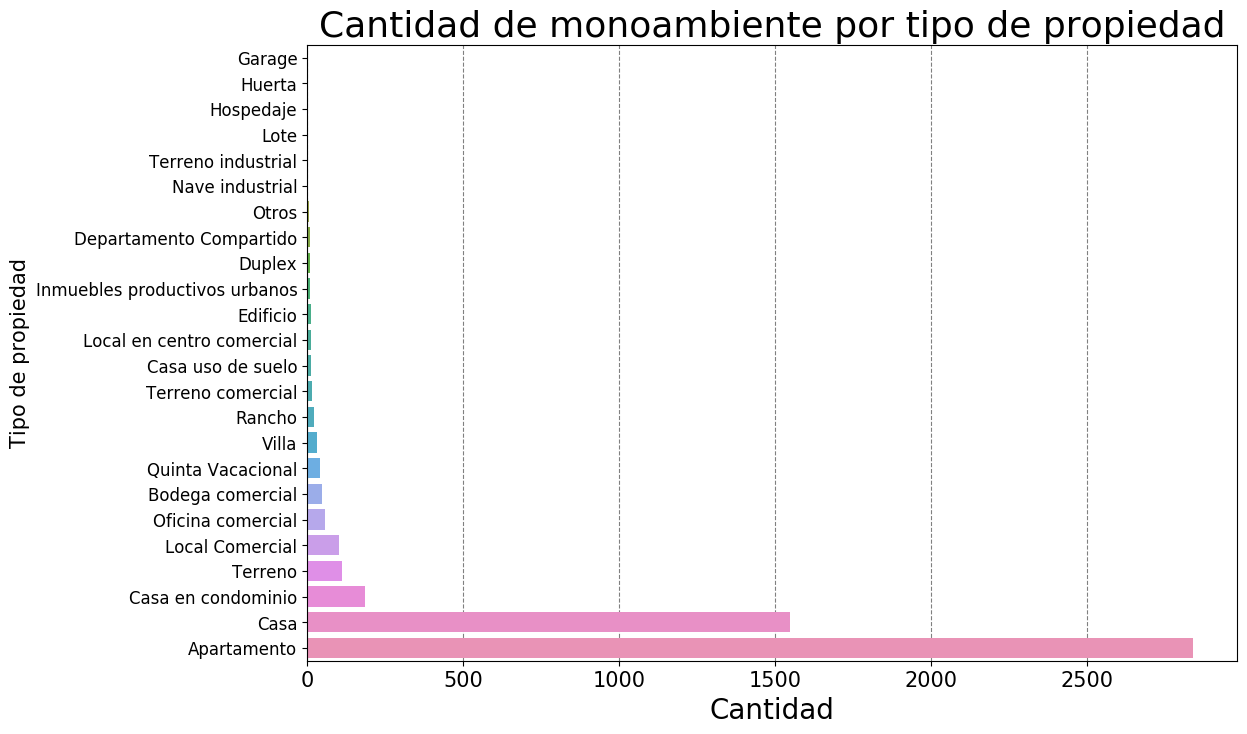

In [231]:
ax = sns.barplot(y=plotear.tipo, x=plotear.cuenta, data=plotear, order=plotear['tipo'])
ax.set_ylabel('Tipo de propiedad', fontsize=15)
ax.set_xlabel('Cantidad', fontsize=20)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=15)
ax.yaxis.grid(False)
ax.set_axisbelow(True)
ax.set_title('Cantidad de monoambiente por tipo de propiedad', fontsize=26);
ax.grid(linestyle='dashed', color='gray')
ax.yaxis.grid(False)

In [232]:
plotear = mono.provincia.value_counts().sort_values()

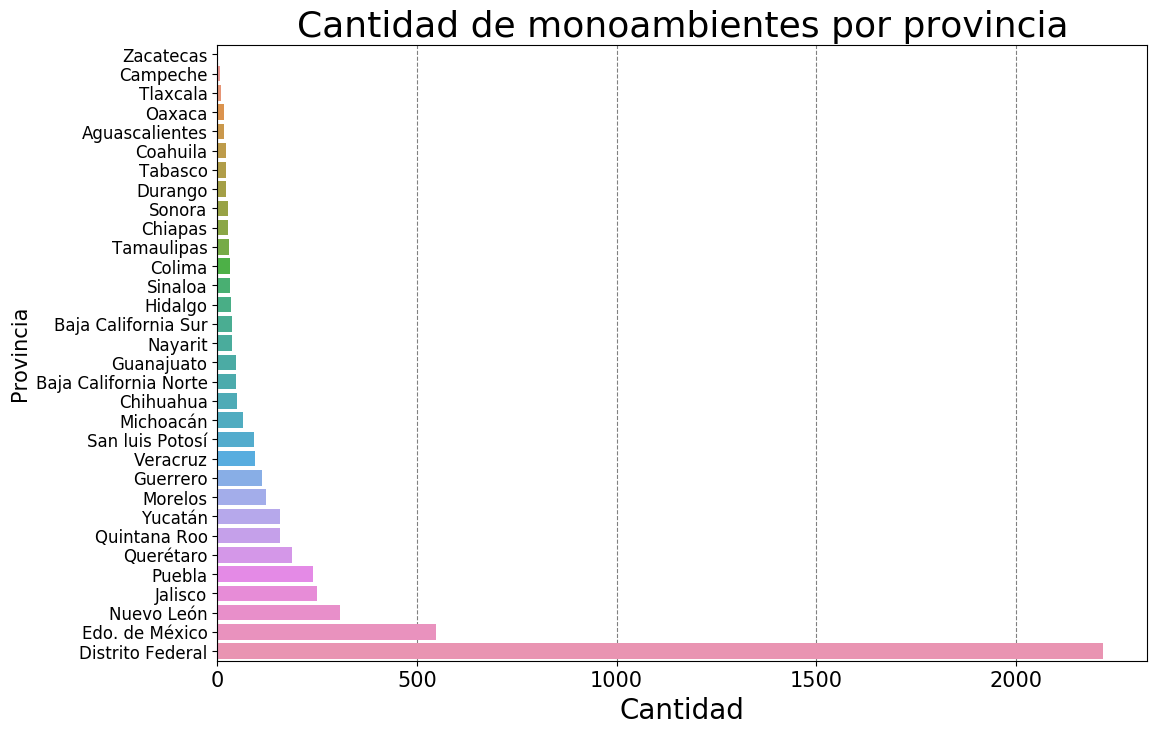

In [233]:
ax = sns.barplot(y=plotear.index, x=plotear.values, order=plotear.index)
ax.set_ylabel('Provincia', fontsize=15)
ax.set_xlabel('Cantidad', fontsize=20)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=15)
ax.yaxis.grid(False)
ax.set_axisbelow(True)
ax.set_title('Cantidad de monoambientes por provincia', fontsize=26);
ax.grid(linestyle='dashed', color='gray')
ax.yaxis.grid(False)

In [234]:
mono_m2_prov = mono.groupby("provincia").agg({"preciom2usd":"mean"}).sort_values(by= "preciom2usd")

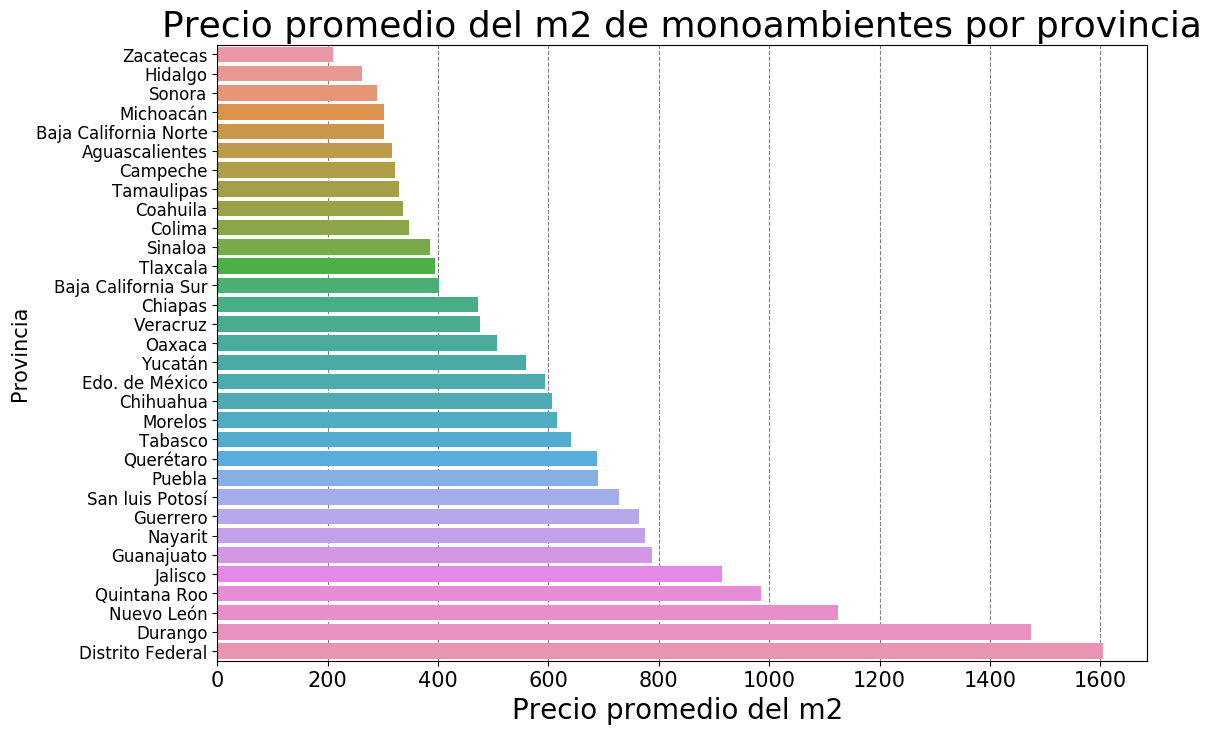

In [235]:
ax = sns.barplot(y=mono_m2_prov.index, x=mono_m2_prov.preciom2usd, order=mono_m2_prov.index)
ax.set_ylabel('Provincia', fontsize=15)
ax.set_xlabel('Precio promedio del m2 ', fontsize=20)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=15)
ax.yaxis.grid(False)
ax.set_axisbelow(True)
ax.set_title('Precio promedio del m2 de monoambientes por provincia', fontsize=26);
ax.grid(linestyle='dashed', color='gray')
ax.yaxis.grid(False)

Text(158.22222222222223, 0.5, 'Año de Publicacion')

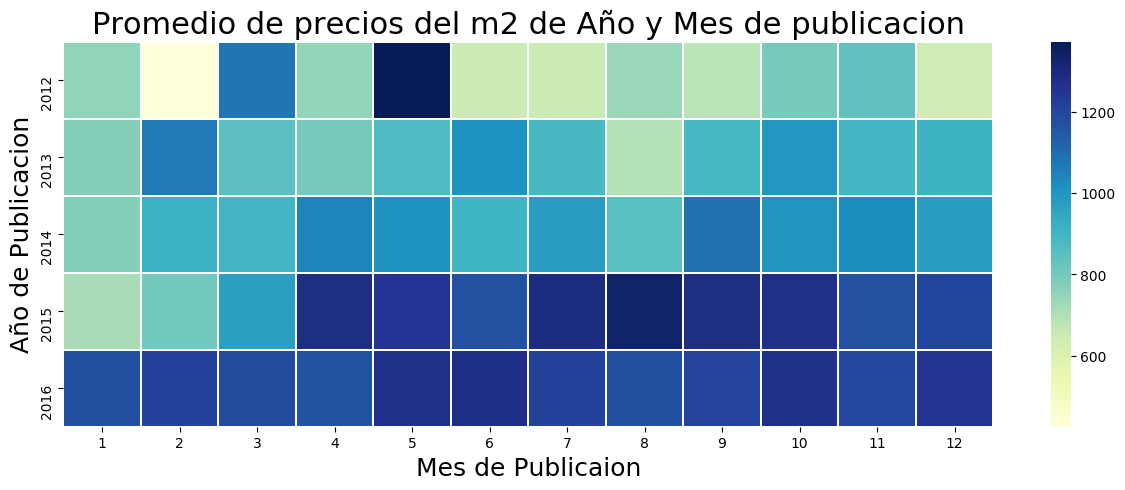

In [236]:
columnas = ["anio de publicacion","mes de publicacion","preciom2usd"]
publicado = mono[columnas]
publicado = publicado.pivot_table(index='anio de publicacion', columns='mes de publicacion', values='preciom2usd', aggfunc='mean')
plt.figure(figsize=(15,5))
g = sns.heatmap(publicado,  cmap="YlGnBu", linewidths=.5)
g.set_ylim(5,-0,1)
g.set_title("Promedio de precios del m2 de Año y Mes de publicacion", fontsize=22)
g.set_xlabel("Mes de Publicaion",fontsize=18)
g.set_ylabel("Año de Publicacion", fontsize=18)

Text(158.22222222222223, 0.5, 'Año de Publicacion')

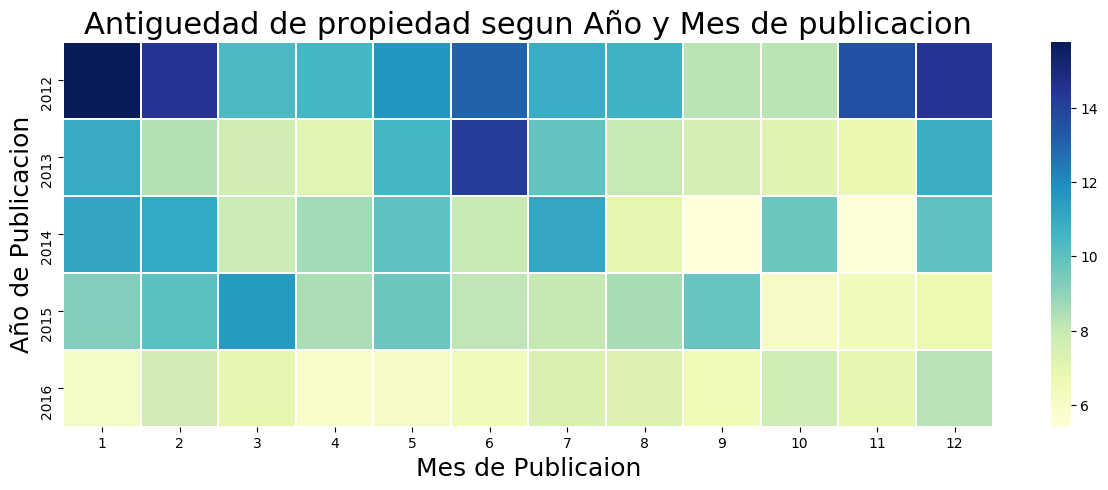

In [237]:
columnas = ["anio de publicacion","mes de publicacion","antiguedad"]
publicado = mono[columnas]
publicado = publicado.pivot_table(index='anio de publicacion', columns='mes de publicacion', values='antiguedad', aggfunc='mean')
plt.figure(figsize=(15,5))
g = sns.heatmap(publicado,  cmap="YlGnBu", linewidths=.5)
g.set_ylim(5,-0,1)
g.set_title("Antiguedad de propiedad segun Año y Mes de publicacion", fontsize=22)
g.set_xlabel("Mes de Publicaion",fontsize=18)
g.set_ylabel("Año de Publicacion", fontsize=18)

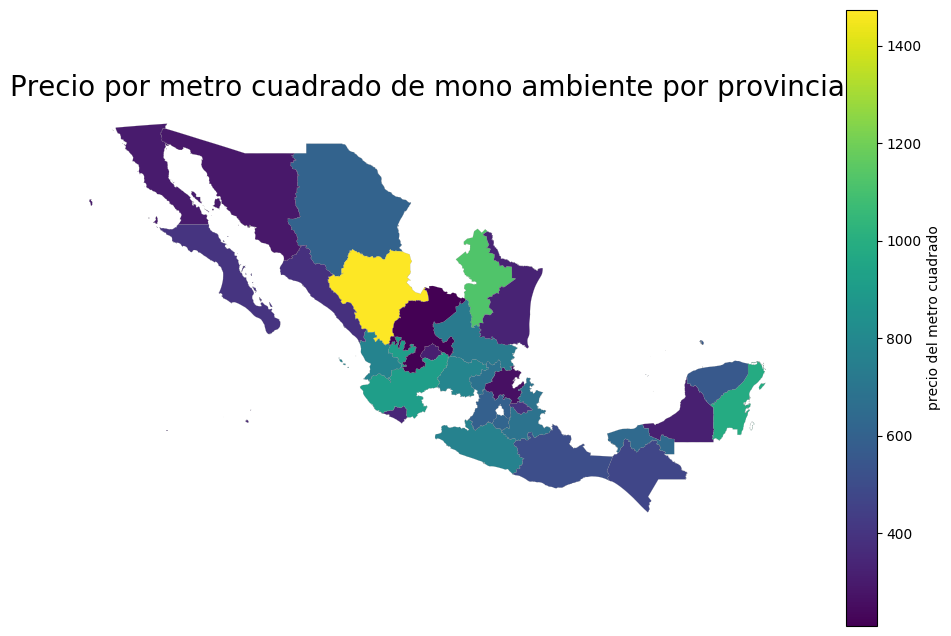

In [238]:
mexico = gpd.read_file('data/shapes/MEX_adm1.shp')

mexico = mexico.rename(columns={"Name":"NAME_1"})

mexico['NAME_1'] = mexico['NAME_1'].map(fix_state_names)

mono_avg_preciom2 = mono.groupby('provincia').agg({'preciom2usd': 'mean'})\
                        .reset_index().rename(columns={'preciom2usd': 'avg preciom2usd'})\
                        .sort_values('avg preciom2usd', ascending=False)

mexico = pd.merge(left=mexico, right=mono_avg_preciom2, left_on='NAME_1', right_on='provincia')

vmin = mexico['avg preciom2usd'].min()
vmax = mexico['avg preciom2usd'].max()

fig, ax = plt.subplots()
mexico.plot(ax=ax, column='avg preciom2usd', cmap='viridis', linewidth=0.1, edgecolor='0.5')

ax.set_title('Precio por metro cuadrado de mono ambiente por provincia', fontsize=20)
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))

sm._A = []
cbar = fig.colorbar(sm)
cbar.set_label('precio del metro cuadrado');

In [239]:
agrupado = mono.groupby("provincia").agg({"antiguedad":"mean"}).sort_values(by="antiguedad")

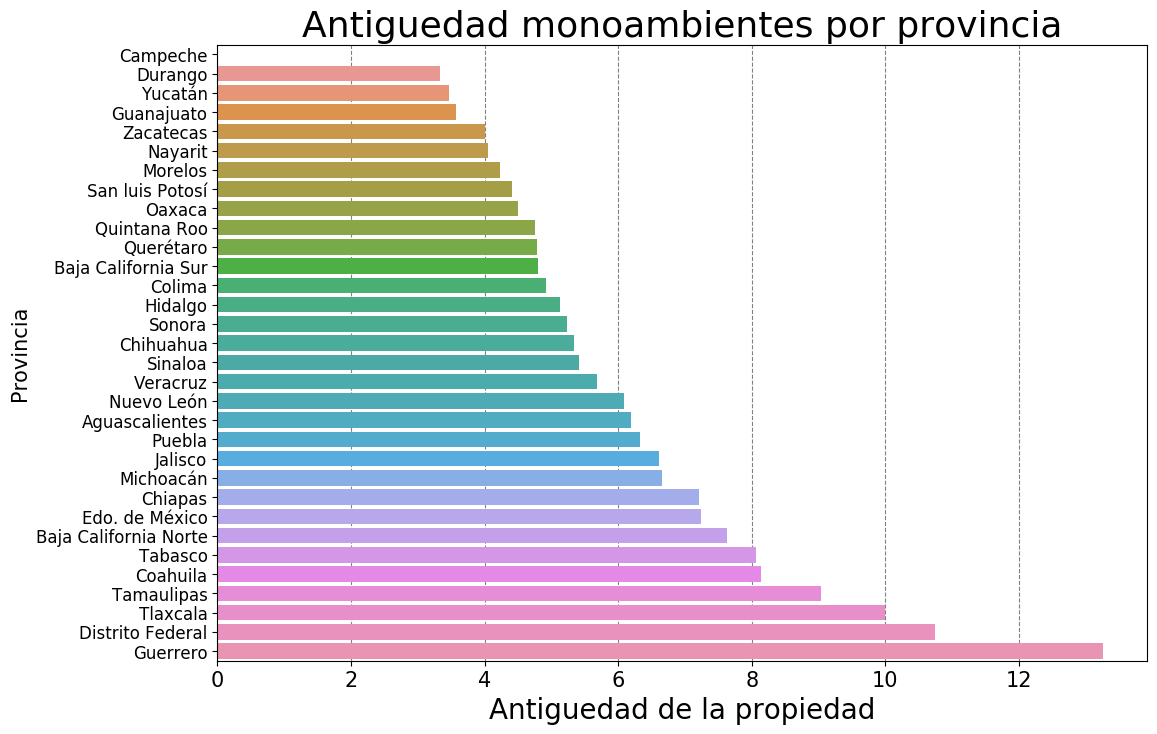

In [240]:
ax = sns.barplot(y=agrupado.index, x=agrupado.antiguedad, order=agrupado.index)
ax.set_ylabel('Provincia', fontsize=15)
ax.set_xlabel('Antiguedad de la propiedad', fontsize=20)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=15)
ax.yaxis.grid(False)
ax.set_axisbelow(True)
ax.set_title('Antiguedad monoambientes por provincia', fontsize=26);
ax.grid(linestyle='dashed', color='gray')
ax.yaxis.grid(False)

Las publicaciones de los monoambientes en campeche son propiedades a estrenar

In [241]:
mono_filter = mono[mono["escuelascercanas"]==1]
agrupado_por_escuelas = mono_filter.groupby("provincia").agg({"escuelascercanas":"count"}).sort_values(by="escuelascercanas")

Se puede ver que Distrito federal es la ciudad con mas escuelas cercanas. Por eso mismo tiene el m2 mas caro tambien ya que es la capital

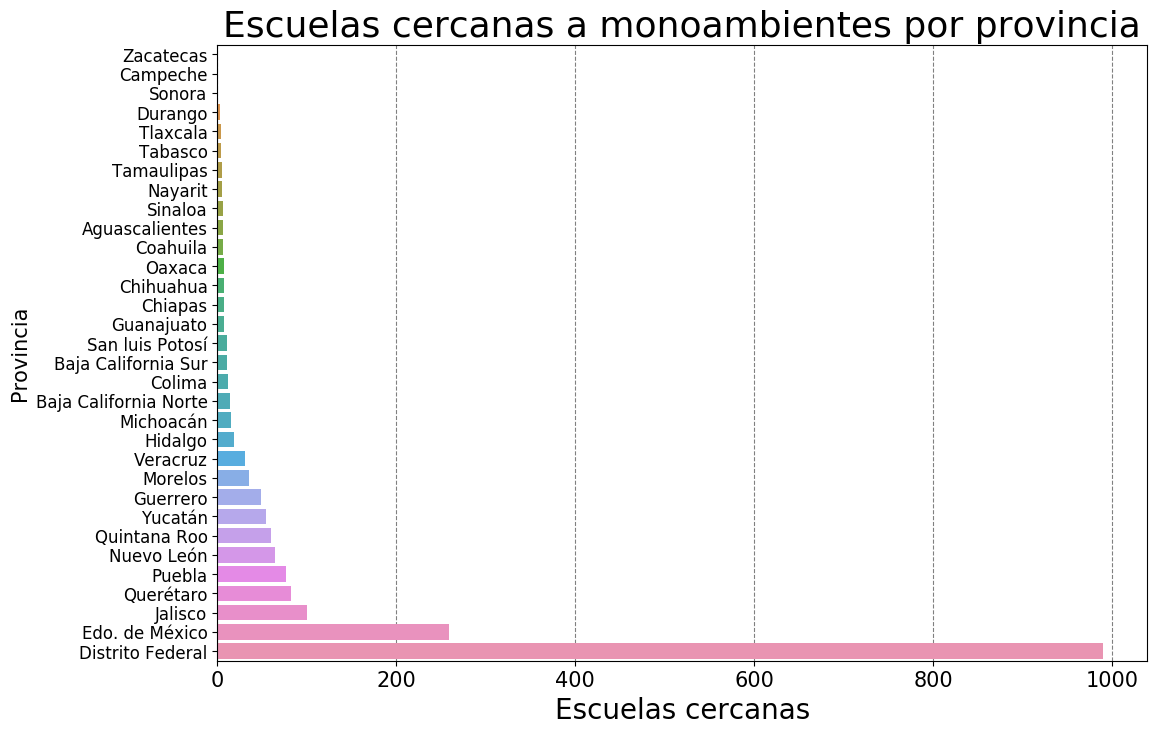

In [242]:
ax = sns.barplot(y=agrupado_por_escuelas.index, x=agrupado_por_escuelas.escuelascercanas, order=agrupado_por_escuelas.index)
ax.set_ylabel('Provincia', fontsize=15)
ax.set_xlabel('Escuelas cercanas', fontsize=20)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=15)
ax.yaxis.grid(False)
ax.set_axisbelow(True)
ax.set_title('Escuelas cercanas a monoambientes por provincia', fontsize=26);
ax.grid(linestyle='dashed', color='gray')
ax.yaxis.grid(False)

In [243]:
mono_filter = mono[~(mono.provincia.isnull())]
mono_filter = mono[~(mono.ciudad.isnull())]
mono_filter['ciudad-provincia'] = mono_filter[['ciudad', 'provincia']].apply(lambda x: ', '.join(x), axis=1)
mono_agrupado_por_ciudad = mono_filter.groupby("ciudad-provincia").agg({"id":"count"}).sort_values(by="id",ascending=False).head(15)

/home/peter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


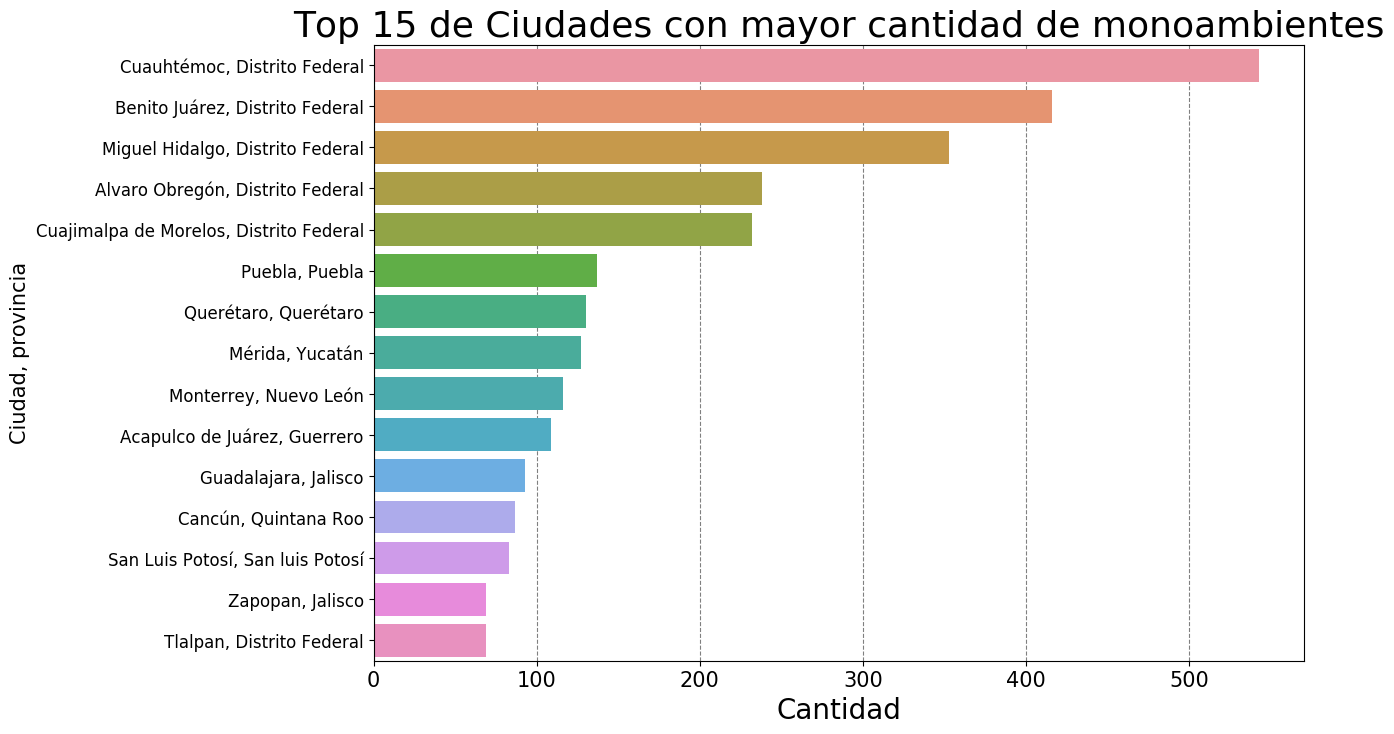

In [247]:
ax = sns.barplot(y=mono_agrupado_por_ciudad.index, x=mono_agrupado_por_ciudad.id, order=mono_agrupado_por_ciudad.index)
ax.set_title('Top 15 de Ciudades con mayor cantidad de monoambientes', fontsize=26);
ax.set_ylabel('Ciudad, provincia', fontsize=15)
ax.set_xlabel('Cantidad', fontsize=20)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=15)
ax.yaxis.grid(False)
ax.set_axisbelow(True)
ax.grid(linestyle='dashed', color='gray')
ax.yaxis.grid(False)

In [245]:
mono_filter_por_escuela = mono_filter[mono_filter["escuelascercanas"]==1]
agrupado_por_escuelas = mono_filter_por_escuela.groupby("ciudad-provincia").agg({"escuelascercanas":"count"}).sort_values(by="escuelascercanas",ascending=False).head(15)

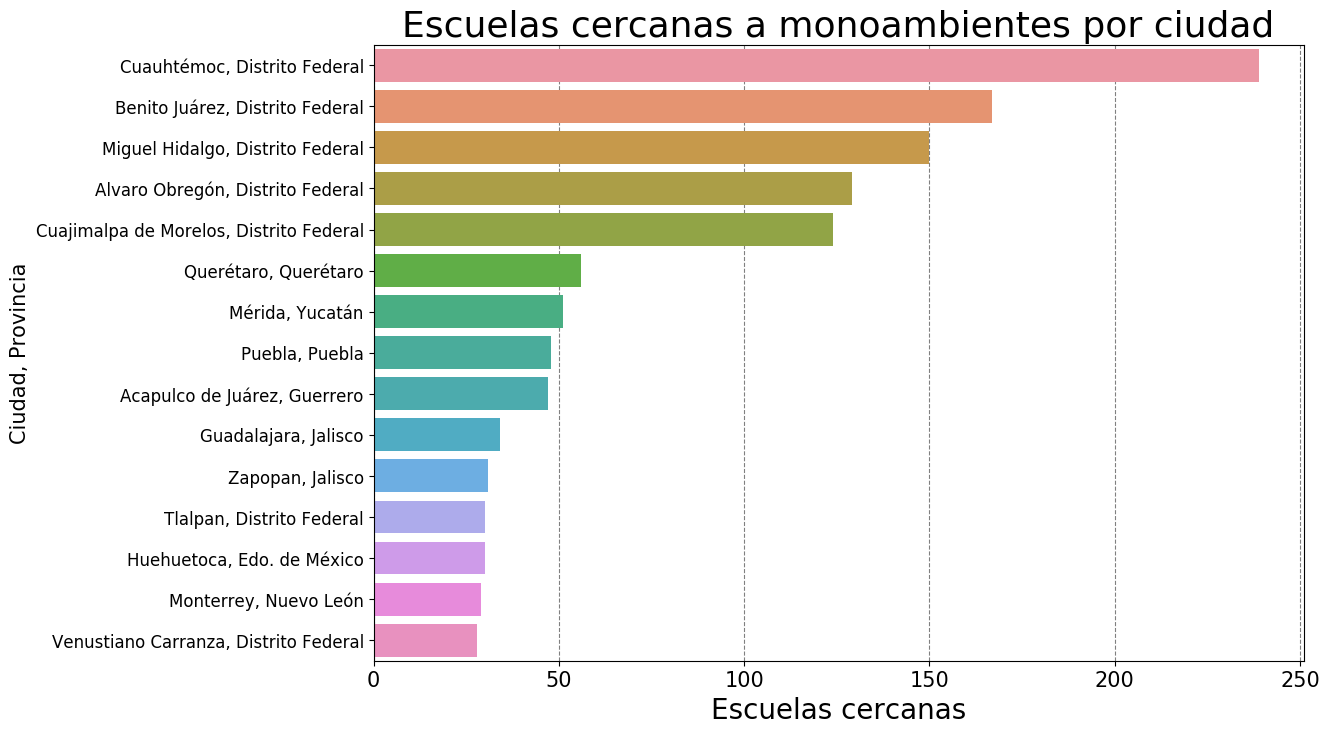

In [248]:
ax = sns.barplot(y=agrupado_por_escuelas.index, x=agrupado_por_escuelas.escuelascercanas, order=agrupado_por_escuelas.index)
ax.set_ylabel('Ciudad, Provincia', fontsize=15)
ax.set_xlabel('Escuelas cercanas', fontsize=20)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=15)
ax.yaxis.grid(False)
ax.set_axisbelow(True)
ax.set_title('Escuelas cercanas a monoambientes por ciudad', fontsize=26);
ax.grid(linestyle='dashed', color='gray')
ax.yaxis.grid(False)

Obviamente por tenes mas cantidad de monoambientes por ciudad, hay mayor cantidad de escuelas cercanas.